# Simulations numériques de l'étude d'impact

Références : 
* *Projet de loi instituant un système universel de retraite.* - Etude d'impact, 24 janvier 2020
* *Évolutions et perspectives des retraites en France.* Rapport annuel du COR – Juin 2019

In [1]:
import sys
sys.path.append(r'retraites')

In [2]:
from SimulateurRetraites import SimulateurRetraites
from SimulateurAnalyse import SimulateurAnalyse
import pylab as pl

## Analyse de l'étude d'impact : dépenses de retraites

Le rapport du COR de Juin 2019 présente les dépenses de retraites jusqu'en 2070. 

![Dépenses constatées et projetées du système de retraite actuel](COR-Depenses-vs-PIB-Juin-2019.png "Dépenses de retraite (COR, Juin 2019)")

Le rapport du COR de Novembre 2019 présente les dépenses de retraites jusqu'à 2030, compte tenu des mesures de restriction des ressources exigées par le gouvernement. 

![Dépenses constatées et projetées du système de retraite actuel](COR-Novembre-2019-Depenses.png "Dépenses de retraite (COR, Novembre 2019)")


L'étude d'impact, page 174, présente une analyse du niveau de dépenses en % de PIB : "Ce taux est plus élevé que ce qu’on observe dans les autres pays européens. Les prestations de vieillesse-survie (correspondant au champ comparable internationalement, plus large que les dépenses du seul système de retraite) représentent 14,4 % du PIB en France, contre 12,6 % du PIB dans l’UE-15 et 12,3 % dans l’UE-28."

Dans l'étude d'impact, page 174, le graphique 58 présente les dépenses constatées et projetées du système de retraite actuel, en points de PIB. 

![Dépenses constatées et projetées du système de retraite actuel](EtudeImpact-depenses-constatees-projetees.png "Dépenses constatées et projetées du système de retraite actuel (Etude d'impact, Janvier 2020")

Analysons cette trajectoire de dépenses par comparaison avec celles du COR.
* Ces dépenses correspondent à celle du COR de Novembre 2019, comme c'est précisé dans l'étude d'impact. 
* Cette trajectoire ne correspond pas à la trajectoire à 1.3% dans le rapport du COR de Juin 2019. En effet, l'étude d'impact évoque la trajectoire de dépenses du rapport du COR de Novembre 2019 (et pas Juin 2019) à +1.3% de hausse des salaires et un taux de chômage de 7%. Or ce scénario mène à un niveau de dépenses de 13.5% en 2050 dans le rapport du COR de Juin 2019, alors que l'étude d'impact est proche de 13%.
* Ces dépenses correspondent approximativement à la trajectoire à +1.5% du rapport de Juin 2019 jusqu'à 2050. 

## Hypothèses : conjoncture

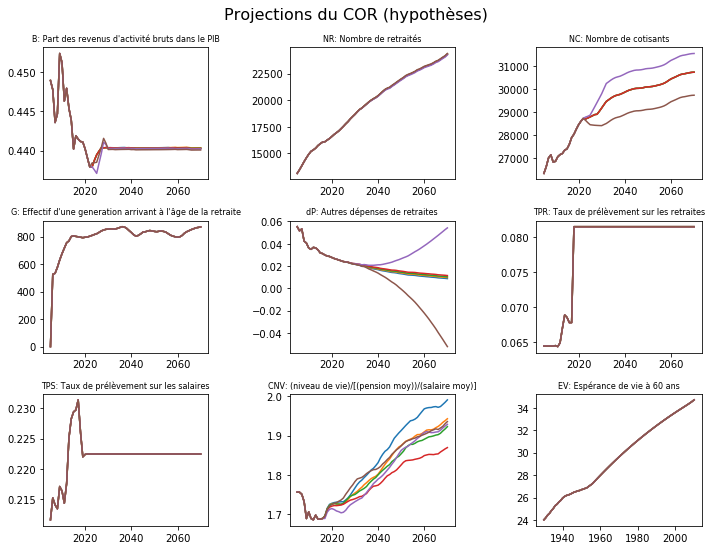

In [3]:
simulateur = SimulateurRetraites('retraites/fileProjection.json')

analyse = simulateur.pilotageCOR()

pl.figure(figsize=(10,8))
pl.suptitle(u"Projections du COR (hypothèses)",fontsize=16)
for c in range(9):
    pl.subplot(3,3,c+1)
    v,V = [ (simulateur.B,'B'), (simulateur.NR,'NR'), (simulateur.NC,'NC'), \
            (simulateur.G,'G'), (simulateur.dP,'dP'), (simulateur.TCR,'TPR'), 
            (simulateur.TCS,'TPS'), (simulateur.CNV,'CNV'), (simulateur.EV,'EV') ][c]
    analyse.graphique(v,V)
pl.tight_layout(rect=[0, 0.03, 1, 0.95])    

## Calcul de la trajectoire de dépenses

## Simulation de l'étude d'impact

Cette stratégie de pilotage est celle dans laquelle :
* le bilan financier est nul,
* l'âge de départ à la retraite est celui du COR (Juin 2019),
* le montant des dépenses sont celles du COR (Juin 2019).

In [4]:
analyse = simulateur.pilotageParAgeEtDepenses()

Utilise l'âge du COR
Utilise les dépenses du COR


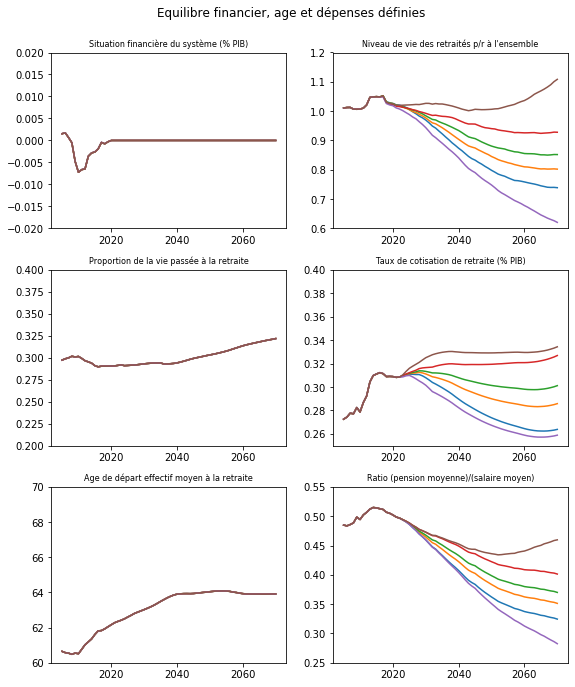

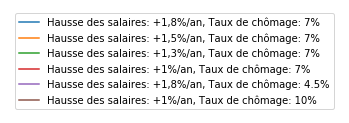

In [5]:
pl.figure(figsize=(8,10))
pl.suptitle(u"Equilibre financier, age et dépenses définies")
analyse.graphiques()
analyse.plot_legend()

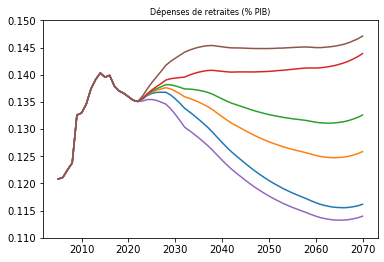

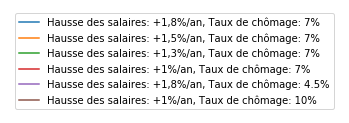

In [9]:
pl.figure()
analyse.graphique(analyse.Depenses,"Depenses")
analyse.plot_legend()

On constate que l'on ne reproduit pas les dépenses indiquées dans l'étude d'impact, mais qu'on reproduit correctement les dépenses du rapport du COR de Juin 2019.